In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statistics as stats

This year's challenge will focus on models to determine whether a patient admitted to an ICU has been diagnosed with a particular type of diabetes, Diabetes Mellitus.

In [2]:
training_data = pd.read_csv('TrainingWiDS2021.csv')

In [3]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130157 entries, 0 to 130156
Columns: 181 entries, Unnamed: 0 to diabetes_mellitus
dtypes: float64(157), int64(18), object(6)
memory usage: 179.7+ MB


In [4]:
training_data.head()

,Unnamed: 0,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,...,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus
0,1,214826,118,68.0,22.732803,0,Caucasian,M,180.3,Floor,...,NaN,NaN,0,0,0,0,0,0,0,1
1,2,246060,81,77.0,27.421875,0,Caucasian,F,160.0,Floor,...,51.0,51.0,0,0,0,0,0,0,0,1
2,3,276985,118,25.0,31.952749,0,Caucasian,F,172.7,Emergency Department,...,NaN,NaN,0,0,0,0,0,0,0,0
3,4,262220,118,81.0,22.635548,1,Caucasian,F,165.1,Operating Room,...,337.0,337.0,0,0,0,0,0,0,0,0
4,5,201746,33,19.0,NaN,0,Caucasian,M,188.0,NaN,...,NaN,NaN,0,0,0,0,0,0,0,0


In [5]:
data_dictionary = pd.read_csv('DataDictionaryWiDS2021.csv')

In [6]:
data_dictionary.head()

,Category,Variable Name,Unit of Measure,Data Type,Description,Example
0,identifier,encounter_id,None,integer,Unique identifier associated with a patient un...,None
1,identifier,hospital_id,None,integer,Unique identifier associated with a hospital,None
2,demographic,age,Years,numeric,The age of the patient on unit admission,None
3,demographic,bmi,kilograms/metres^2,string,The body mass index of the person on unit admi...,21.5
4,demographic,elective_surgery,None,binary,Whether the patient was admitted to the hospit...,0


In [7]:
data_dictionary['Category'].unique()

array(['identifier', 'demographic', 'APACHE covariate', 'vitals', 'labs',
       'labs blood gas', 'APACHE comorbidity', 'Target Variable'],
      dtype=object)

## Data quality (and cleaning)

### Reconciling the data dictionary with the training data

In [8]:
set(training_data.keys()) ^ set(data_dictionary['Variable Name'].unique())

{'Unnamed: 0', 'icu_admit_type'}

In [9]:
data_dictionary['Description'][data_dictionary['Variable Name']=='icu_admit_type']

10    The type of unit admission for the patient
Name: Description, dtype: object

In [10]:
training_data.filter(like='icu',axis=1).head()

,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days
0,Floor,92,admit,CTICU,0.541667
1,Floor,90,admit,Med-Surg ICU,0.927778
2,Accident & Emergency,93,admit,Med-Surg ICU,0.000694
3,Operating Room / Recovery,92,admit,CTICU,0.000694
4,Accident & Emergency,91,admit,Med-Surg ICU,0.073611


In [11]:
data_dictionary = data_dictionary[data_dictionary['Variable Name'] != 'icu_admit_type']

In [12]:
training_data.drop(columns='Unnamed: 0',axis=1,inplace=True)
training_data.head()

,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,...,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus
0,214826,118,68.0,22.732803,0,Caucasian,M,180.3,Floor,Floor,...,NaN,NaN,0,0,0,0,0,0,0,1
1,246060,81,77.0,27.421875,0,Caucasian,F,160.0,Floor,Floor,...,51.0,51.0,0,0,0,0,0,0,0,1
2,276985,118,25.0,31.952749,0,Caucasian,F,172.7,Emergency Department,Accident & Emergency,...,NaN,NaN,0,0,0,0,0,0,0,0
3,262220,118,81.0,22.635548,1,Caucasian,F,165.1,Operating Room,Operating Room / Recovery,...,337.0,337.0,0,0,0,0,0,0,0,0
4,201746,33,19.0,NaN,0,Caucasian,M,188.0,NaN,Accident & Emergency,...,NaN,NaN,0,0,0,0,0,0,0,0


### Data verifications

In [13]:
data_dictionary[data_dictionary['Variable Name']=='height']['Unit of Measure']

7    centimetres
Name: Unit of Measure, dtype: object

In [14]:
data_dictionary[data_dictionary['Variable Name']=='weight']['Unit of Measure']

16    kilograms
Name: Unit of Measure, dtype: object

In [15]:
# feature engineer BMI
training_data['bmi'] = training_data['weight']/(training_data['height']/100)**2

In [16]:
# check for patient redundancy
np.max(training_data['encounter_id'].value_counts())

1

In [44]:
# drop hospital_id
df = training_data.drop(columns='hospital_id')

### Missing data

In [55]:
# drop where more than half of the values are missing 
df.dropna(thresh=90,inplace=True)

In [58]:
# drop where age or bmi is missing - these are expected to be important predictors which cannot be imputed easily
df.dropna(subset=['age','bmi'],inplace=True)

In [59]:
missing_data_df = np.sum(df.isnull())/len(df)

In [60]:
# where data is missing for more than 45% of entries, drop columns
df.drop(columns = missing_data_df[missing_data_df>0.45].keys(),inplace=True)

In [61]:
missing_data_df = np.sum(df.isnull())/len(df)

In [96]:
# check the remaining missing values
missing_data_df[missing_data_df>0.1]

hospital_admit_source    0.261983
bun_apache               0.110221
creatinine_apache        0.107964
hematocrit_apache        0.141256
sodium_apache            0.104342
wbc_apache               0.157935
h1_temp_max              0.202283
h1_temp_min              0.202283
dtype: float64

In [73]:
for i in missing_data_df[missing_data_df>0.1].keys():
    print(str(i))

hospital_admit_source
bun_apache
creatinine_apache
hematocrit_apache
sodium_apache
wbc_apache
h1_temp_max
h1_temp_min


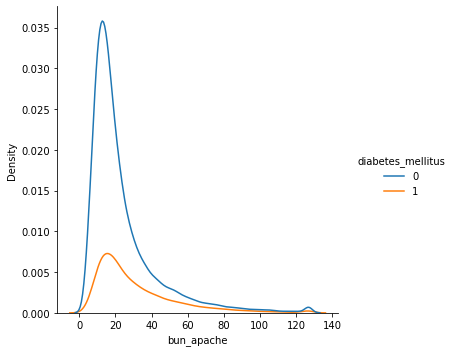

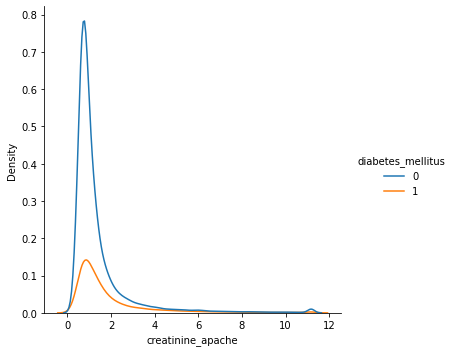

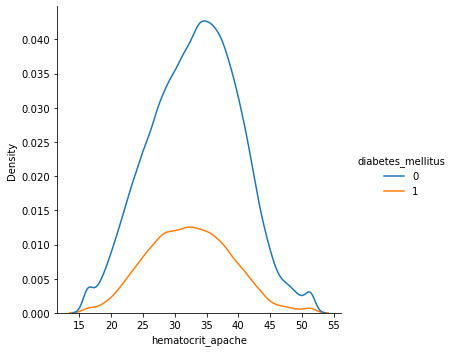

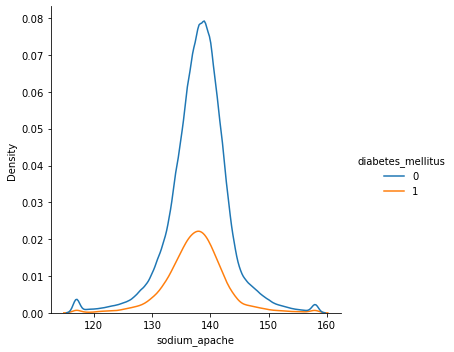

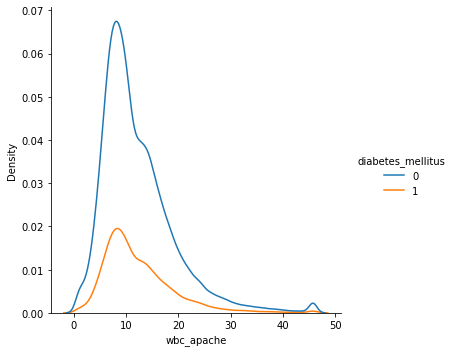

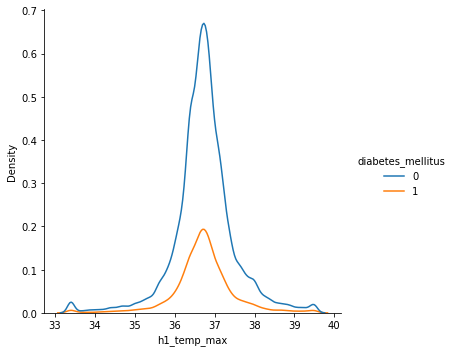

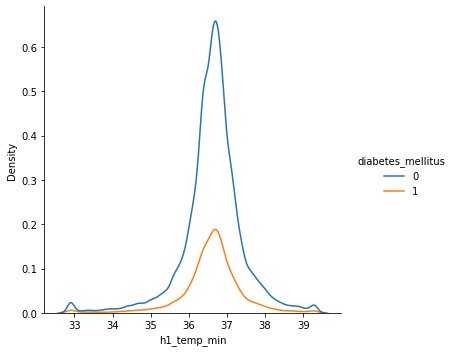

In [91]:
# check the predictive value of these features
# sns.displot(data=penguins, x="flipper_length_mm", hue="species", col="sex", kind="kde")
for i in missing_data_df[missing_data_df>0.1].keys():
    if df[i].dtype == 'float64':
        sns.displot(data=df,x=i,hue='diabetes_mellitus',kind='kde')

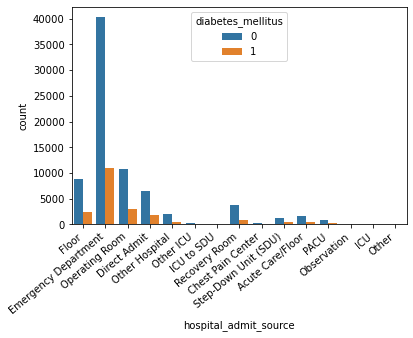

In [31]:
fig = plt.figure()
ax = sns.countplot(data=df,x='hospital_admit_source',hue='diabetes_mellitus')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

In [93]:
# We'll drop the hospial_admit_source because its impact on diabetes is confusing anyway. 
# For the rest, we'll impute

AttributeError: 'Series' object has no attribute 'filna'

In [ ]:
# Any remaining will just be dropped 

### Redundant data

#### Correlations between variables

In [133]:
data_dictionary['Category'].unique()

array(['identifier', 'demographic', 'APACHE covariate', 'vitals', 'labs',
       'labs blood gas', 'APACHE comorbidity', 'Target Variable'],
      dtype=object)

<AxesSubplot:>

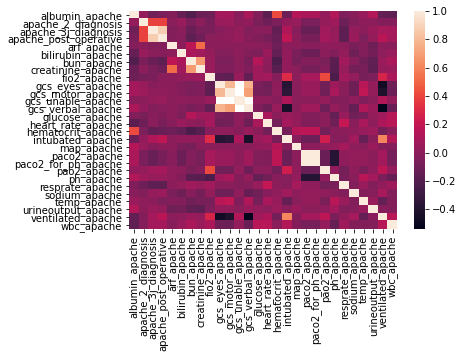

In [210]:
sns.heatmap(training_data[data_dictionary[data_dictionary['Category']=='APACHE covariate']['Variable Name']].corr(),xticklabels=True, yticklabels=True)

Observation: fairly high cross correlation between gcs measurements

<AxesSubplot:>

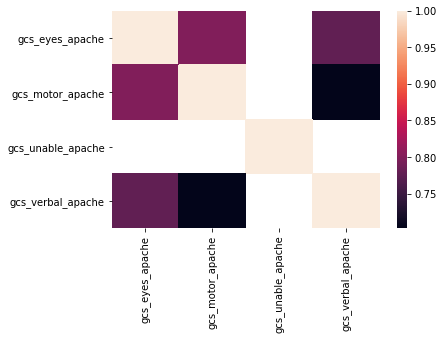

In [152]:
sns.heatmap(training_data[data_dictionary[data_dictionary['Category']=='APACHE covariate']['Variable Name']].filter(like='gcs').corr())

<AxesSubplot:>

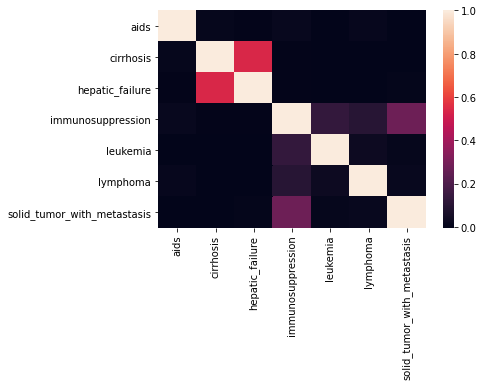

In [136]:
sns.heatmap(training_data[data_dictionary[data_dictionary['Category']=='APACHE comorbidity']['Variable Name']].corr())

Observation: cirrhosis (scarring of the liver) often coincides with hepatic failure: By crosstabulating, we can see that it is about 50% likely that if there was cirrhosis there was hepatic failure also

In [148]:
pd.crosstab(training_data['cirrhosis'],training_data['hepatic_failure'])

hepatic_failure,0,1
cirrhosis,,
0,127342,722
1,1045,1048


Note: d1 refers to day 1, h1 refers to hour 1 on day 1

<AxesSubplot:>

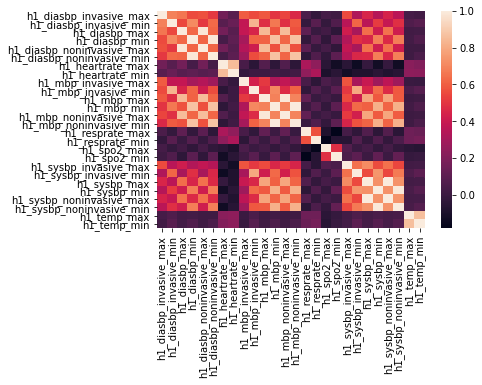

In [211]:
sns.heatmap(training_data[data_dictionary[data_dictionary['Category']=='vitals']['Variable Name']].filter(like='h1').corr(),xticklabels=True, yticklabels=True)

Observation: high cross correlation across all blood pressure measures (diasbp, mbp, sysbp)

<AxesSubplot:>

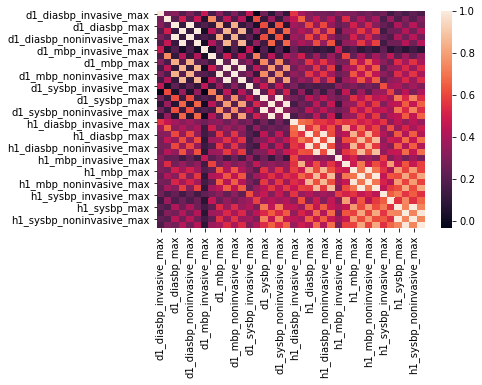

In [213]:
sns.heatmap(training_data[data_dictionary[data_dictionary['Category']=='vitals']['Variable Name']].filter(like='bp').corr())

Observation: high correlation between d1 and h1 measures

<AxesSubplot:>

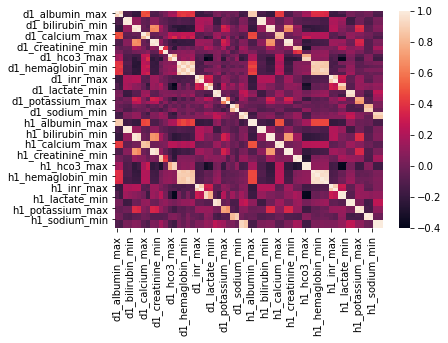

In [142]:
sns.heatmap(training_data[data_dictionary[data_dictionary['Category']=='labs']['Variable Name']].corr())

<AxesSubplot:>

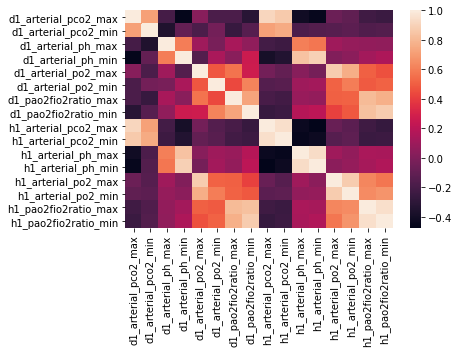

In [145]:
sns.heatmap(training_data[data_dictionary[data_dictionary['Category']=='labs blood gas']['Variable Name']].corr())

<AxesSubplot:>

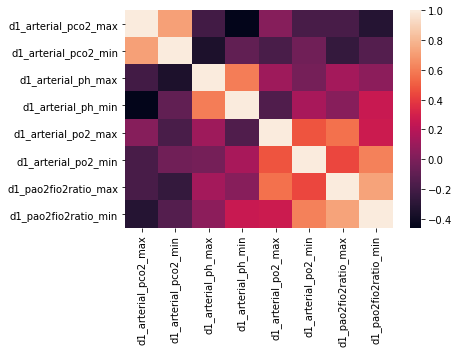

In [154]:
sns.heatmap(training_data[data_dictionary[data_dictionary['Category']=='labs blood gas']['Variable Name']].filter(like='d1').corr())